# Tutorial for params_MOT

This package fits various parameters to images of molecules or atoms trapped in a magneto-optical trap (MOT).

In [1]:
%matplotlib inline 

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters
import seaborn as sns
import pandas as pd
import os

import math
import emcee

from params_MOT.io_package import get_data_file_path, load_data
from params_MOT.model import *
from params_MOT import MOT_image
import params_MOT as pm

from scipy.optimize import curve_fit

### Set parameters

In [2]:
#mc_params=(Walkers,Steps)
mc_params=(200,800)

#initial_guess = [center_x, center_y, amplitude, sigma_x, sigma_y, background_offset, sigma_m, readout_charge]
initial_guess = [25, 25, 100, 10, 10, 100, 20, 60]


### Run Model on Data and Show Results

The MCMC is contained in the function find_params_MOT in model.py. This function runs MCMC using the pm.sampler function, which calls upon the emcee package to compute marginal posteriors for the model parameters. There are 8 parameters to be marginalized over, which is encompassed in the variable theta in our package. theta is an array consisting of the following parameters:
(center_x, center_y, amplitude, sigma_x, sigma_y, background_offset, sigma_m, sigma_g)
The first 5 parameters give the 2D Gaussian for the MOT. background_offset is self-explanator. sigma_m is the uncertainty in the model, and sigma_m is the uncertainty from the scattered light background. When calling upon the find_params_MOT function, we have to specify an 8-tuple consisting of the initial guesses for theta, and also the duple mc_params = (nwalkers, nsteps) which controls the parameters of the MCMC.
From there one only needs to specify the filename of the data (which is presumed to be in the root folder of params_MOT, and the function will automatically run the MCMC and conclude the best fit parameters from the 50th percentile of the final state of the walkers.

Loading data...
The life time of and the laser power used on the MOT are 3 ms and 1/16 (fractional units out of the max power, which is 60mW per beam)
Data loaded. Setting up emcee sampler...
Emcee sampler setup finished. Running MCMC...
       sigma_x   sigma_y
0.16  5.173940  5.467686
0.50  5.292818  5.625578
0.84  5.416916  5.791889


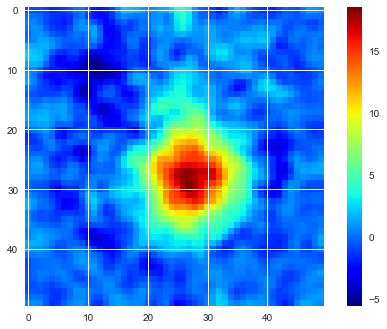

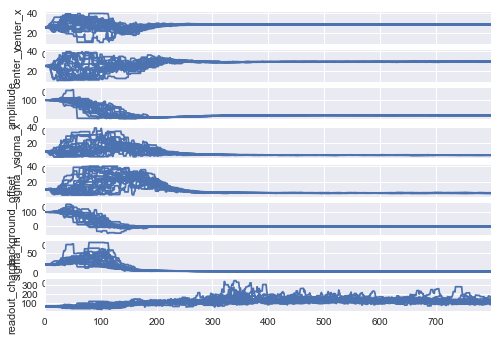

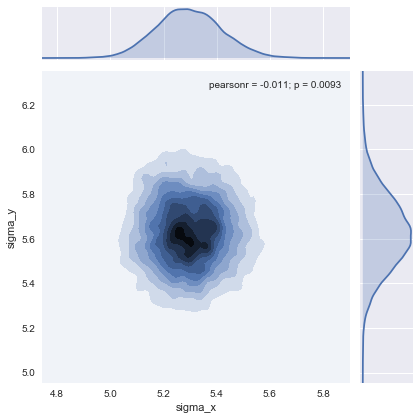

In [3]:
a = find_params_MOT('3_1_16power.csv',50,mc_params,initial_guess, supressMessages = False)

## Get the temperature

To get the temperature from the MOT size (i.e., from the standard deviations $\sigma_\mathrm{x}$ and $\sigma_\mathrm{y}$) we use the following formula: $$\sigma^2 = \sigma^2_{\mathrm{0}} + K_\mathrm{B} T \tau^2 /m,$$ where $\sigma$ stands for either $\sigma_{\mathrm{x}}$ or $\sigma_{\mathrm{y}}$, $\tau$ is the time, $T$ is temperature, $K_\mathrm{B}$ the Boltzmann constant, and $m$ the mass (= 59 amu = 9.80e-26 kg). 

Run the sampler on multiple data files and tabulate their inferred parameters:

In [4]:
# Get the data files 
#(NOTE: this works if you have a folder called "data" one step up from the main repo folder; the data folder is not uploaded on GitHub)
data_path = '../data'
data_files = [f for f in os.listdir(data_path) if (os.path.isfile(os.path.join(data_path, f)) and f.split('.')[-1] == 'csv')]
print(data_files)

# Run sampler on all data files
q = find_params_MOTs(data_files, 50, mc_params, initial_guess, supressMessages = True)

['0.5_1_16power.csv', '2_1_16power.csv', '3_1_16power.csv', '4_1_16power.csv']


Call function to infer the temeprature for the MOT, corresponding to each direction (for one number use formula $T = T_{\mathrm{x}}^{2/3} \times T_{\mathrm{y}}^{1/3}$).

NOTE: 
   - The true image size is 20 mm x 20 mm, so account for that too.
   - Time is in ms.
   - The power is given as the fraction of the max_power (which is 60 mW). 

     time    power   sigma_x  sigma_sigma_x   sigma_y  sigma_sigma_y  \
0  0.0005  0.00375  0.001923   3.345007e-07  0.001738   2.901502e-08   
1  0.0020  0.00375  0.002019   1.974328e-06  0.001974   1.869560e-06   
2  0.0030  0.00375  0.002116   1.127749e-06  0.002252   2.578148e-06   
3  0.0040  0.00375  0.002456   1.741198e-06  0.002340   2.120541e-07   

   sigma_x_squared  sigma_sigma_x_squared  sigma_y_squared  \
0         0.000004           6.690013e-07         0.000003   
1         0.000004           3.948656e-06         0.000004   
2         0.000004           2.255497e-06         0.000005   
3         0.000006           3.482396e-06         0.000005   

   sigma_sigma_y_squared  
0           5.803004e-08  
1           3.739121e-06  
2           5.156296e-06  
3           4.241082e-07  
The covariance matrix is 
 [[  6.97831005e-15  -7.13147364e-10]
 [ -7.13147364e-10   4.70879554e-04]]


The fitted model, including uncertainties is (0.1238 +- 0.0217)x^2 + (0 +- 0)


The covar

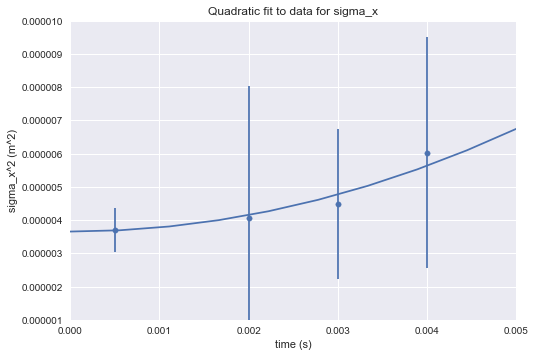

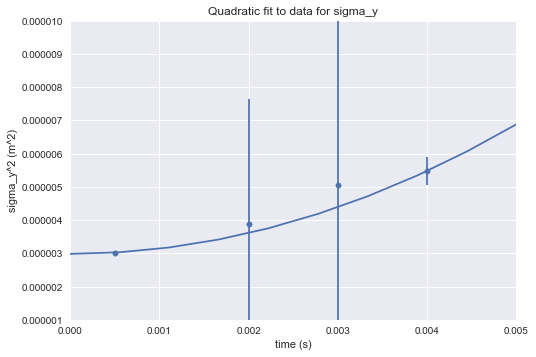

The fitted temepratures: T_x = 0.879127 mK, T_y = 1.108132 mK, T = 0.949653 mK


[0.00087912698130178184, 0.001108132363230947, 0.00094965301713433601]

In [5]:
pm.find_MOT_temp (q, pixel_distance_ratio = 0.4*10**(-3), time_conversion_ratio = 10**(-3), max_power = 60*10**(-3), supressMessages = False)